## I. Import packages

In [1]:
import os
import numpy as np

import keras
from keras.models import Model

import random
from PIL import Image
from sklearn.decomposition import PCA
from scipy.spatial import distance
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## II. Construct VGG16 model and load weights into it

### II.I. Define hyperparameters

In [2]:
images_path = '101_ObjectCategories'
features_path = 'features_vgg16.npy'
num_images = 10000
pca_components = 1000
num_closest_matches = 7

### II.II. Define model

In [3]:
model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                                       input_tensor=None, input_shape=(224,224,3), pooling=None, classes=1000)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
model = Model(inputs=model.input, outputs=model.get_layer('fc2').output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## III. Extract 4096-features for images of 101_ObjectCategories using the VGG16 model pretrained on ImageNet

In [5]:
def get_image(path):
    img = Image.open(path)
    if img.mode != 'RGB':  img = img.convert('RGB')
    img = img.resize((224, 224), Image.ANTIALIAS)
    img = np.array(img.getdata(), np.uint8)
    img = img.reshape(224, 224, 3).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames
          if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

if num_images < len(images):  images = [images[i] for i in sorted(random.sample(range(len(images)), num_images))]
else:  num_images = len(images)

In [7]:
def get_features(model, images, features_path):
    if not os.path.exists(features_path):
        print("Keeping %d images to analyze" % len(images))
        print()
        features = np.array([])
        for idx,image_path in enumerate(images):
            if idx%100 == 0:  print("Getting features for %d/%d %s" % (idx+1, len(images), image_path))
            image = get_image(image_path);
            feat = model.predict(image)[0]
            features = np.append(features, feat)
        
        features = features.reshape((-1, np.array(model.output_shape[1:]).prod()))
        np.save(features_path, features)
        print()
        print('Saved features to disk at location: ' + features_path + ' !!!')
        
    else:
        print('Loading features in memory from location: ' + features_path + ' ... ... ...')
        features = np.load(features_path)
        print('Features successfully loaded !!!')
    
    return features

In [8]:
features = get_features(model, images, features_path)

Loading features in memory from location: features_vgg16.npy ... ... ...
Features successfully loaded !!!


## IV. Reduce the 4096 dimensions using PCA, preserving optimal variance

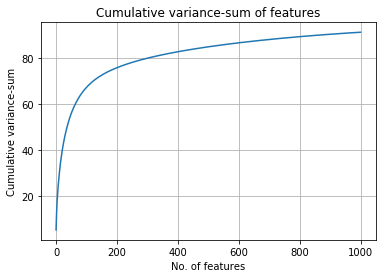

In [9]:
pca_features = PCA(pca_components)
pca_features.fit_transform(features)

var = np.cumsum(pca_features.explained_variance_ratio_*100)
plt.plot(var)
plt.title('Cumulative variance-sum of features')
plt.xlabel('No. of features')
plt.ylabel('Cumulative variance-sum')
plt.grid(True)
plt.show()

In [10]:
pca_features = PCA(n_components=800).fit_transform(features)

## V. Functions for finding images most similar to the query image and for concatenating images

In [11]:
def get_closest_images_idx(query_image_idx, num_results=5):
    thumb_height = 200
    distances = [distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    dists = [round(distances[i], 2) for i in idx_closest]
    return idx_closest, dists

In [12]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = Image.open(images[idx])
        width = height = 224
        img = img.resize((int(width * thumb_height / height), thumb_height), Image.ANTIALIAS)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

## VI. Perform a query

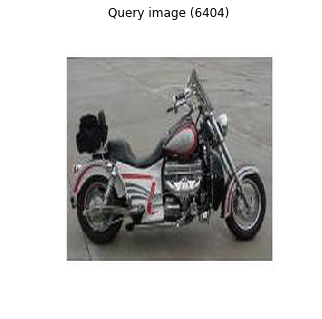

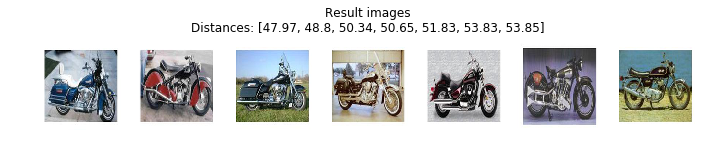

In [14]:
query_image_idx = int(num_images*random.random())
idx_closest, dists = get_closest_images_idx(query_image_idx, num_closest_matches)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

plt.figure(figsize = (5,5))
imshow(query_image)
plt.title("Query image (%d)" % query_image_idx)
plt.axis('off')
plt.figure(figsize = (12,12))
imshow(results_image)
plt.title("Result images\nDistances: " + str(dists))
plt.axis('off')
plt.show()